In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='********************************', project_access_token='p-b5445ffcd7767e7d63da8f9a38ec0906547e3ac6')
pc = project.project_context


# Asignación de presupuesto de marketing en un banco.

## 1. Carga y Análisis

### Importar librerías

In [2]:
# Celda: 1
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

### Cargar nuevos datos

In [3]:
# Celda: 2

import pandas as pd
file = project.get_file("clientes.csv")
clientes = pd.read_csv(file,sep=";")
clientes.head(10)

,ID,tarjeta_credito,prestamo_hipotecario
0,5409,1,0
1,5477,0,0
2,5507,0,1
3,8,0,0
4,158,1,0
5,173,0,0
6,5408,0,1
7,5579,0,0
8,63318,1,0
9,5732,1,1


In [4]:
clientes.shape

(2000, 3)

### Analizar nuevos datos

In [5]:
# Celda: 3

a = clientes[clientes.tarjeta_credito == 1]
b = clientes[clientes.prestamo_hipotecario == 1]
print("Número de potenciales clientes: %d" %len(clientes))
print("Número de potenciales clientes que se predice solicitarán tarjeta_credito: %d" %len(a))
print("Número de potenciales clientes que se predice solicitarán prestamo_hipotecario: %d" %len(b))

Número de potenciales clientes: 2000
Número de potenciales clientes que se predice solicitarán tarjeta_credito: 320
Número de potenciales clientes que se predice solicitarán prestamo_hipotecario: 269


## 2. Definición del modelo

In [6]:
# Celda: 4

import docplex.mp

In [7]:
# Celda: 5

from docplex.mp.model import Model
mdl = Model(name="Asignación Presupuesto Marketing", checker='on')

## 3. Agregar variables al modelo

In [8]:
# Celda: 6

productos = ["tarjeta_credito", "prestamo_hipotecario"]

In [9]:
# Celda: 7

# ¿Cuántos ingresos genera vender cada producto?
valorProducto = [200, 400]
valor_por_producto = {'tarjeta_credito': 200, 'prestamo_hipotecario': 400}

In [10]:
# Celda: 8

# Presupuesto total disponible
presupuestoDisponible = 15000

In [11]:
# Celda: 9

# Para cada canal, el costo de realizar la campaña por ese medio y el factor de éxito
canales =  pd.DataFrame(columns=["nombre", "costo", "factor"], 
                            data=[("llamada telefonica", 23.0, 0.30), 
                                  ("email", 15.0, 0.05), 
                                  ("redes sociales", 20.0, 0.15)])

In [12]:
# Celda: 10

canales.head()

,nombre,costo,factor
0,llamada telefonica,23.0,0.30
1,email,15.0,0.05
2,redes sociales,20.0,0.15


In [13]:
# Celda: 11

clientesR = range(0, len(clientes))
productosR = range(0, len(productos))
canalesR = range(0, len(canales))

In [14]:
# Celda: 12

print(clientesR)
print(productosR)
print(canalesR)

range(0, 2000)
range(0, 2)
range(0, 3)


### Definir las variables de decisión.
- Las variables de decisión de enteros canalesVar, representan si un cliente recibirá o no una oferta para un producto en particular a través de un canal en particular.
- La variable de decisión entera ofertas total representa el número total de ofertas realizadas.
- El presupuestoGastado representa el costo total de las ofertas realizadas.

In [15]:
# Celda: 13

canalesVar = mdl.binary_var_cube(clientesR, productosR, canalesR)
canalesVar

{(0, 0, 0): docplex.mp.Var(type=B),
 (0, 0, 1): docplex.mp.Var(type=B),
 (0, 0, 2): docplex.mp.Var(type=B),
 (0, 1, 0): docplex.mp.Var(type=B),
 (0, 1, 1): docplex.mp.Var(type=B),
 (0, 1, 2): docplex.mp.Var(type=B),
 (1, 0, 0): docplex.mp.Var(type=B),
 (1, 0, 1): docplex.mp.Var(type=B),
 (1, 0, 2): docplex.mp.Var(type=B),
 (1, 1, 0): docplex.mp.Var(type=B),
 (1, 1, 1): docplex.mp.Var(type=B),
 (1, 1, 2): docplex.mp.Var(type=B),
 (2, 0, 0): docplex.mp.Var(type=B),
 (2, 0, 1): docplex.mp.Var(type=B),
 (2, 0, 2): docplex.mp.Var(type=B),
 (2, 1, 0): docplex.mp.Var(type=B),
 (2, 1, 1): docplex.mp.Var(type=B),
 (2, 1, 2): docplex.mp.Var(type=B),
 (3, 0, 0): docplex.mp.Var(type=B),
 (3, 0, 1): docplex.mp.Var(type=B),
 (3, 0, 2): docplex.mp.Var(type=B),
 (3, 1, 0): docplex.mp.Var(type=B),
 (3, 1, 1): docplex.mp.Var(type=B),
 (3, 1, 2): docplex.mp.Var(type=B),
 (4, 0, 0): docplex.mp.Var(type=B),
 (4, 0, 1): docplex.mp.Var(type=B),
 (4, 0, 2): docplex.mp.Var(type=B),
 (4, 1, 0): docplex.mp.Var(t

## 4. Agregar restricciones al modelo
- Ofrecer solo un producto por cliente.
- Calcule el presupuesto y establezca un máximo en él.
- Calcule la cantidad de ofertas a realizar.
- Asegúrese de que al menos el 10% de las ofertas se realicen a través de cada canal.

### Como máximo se ofrece 1 producto a cada cliente

In [16]:
# Celda: 14

mdl.add_constraints(mdl.sum(canalesVar[o,p,c] for p in productosR for c in canalesR) <=1
                   for o in clientesR)

[docplex.mp.LinearConstraint[](x1+x2+x3+x4+x5+x6,LE,1),
 docplex.mp.LinearConstraint[](x7+x8+x9+x10+x11+x12,LE,1),
 docplex.mp.LinearConstraint[](x13+x14+x15+x16+x17+x18,LE,1),
 docplex.mp.LinearConstraint[](x19+x20+x21+x22+x23+x24,LE,1),
 docplex.mp.LinearConstraint[](x25+x26+x27+x28+x29+x30,LE,1),
 docplex.mp.LinearConstraint[](x31+x32+x33+x34+x35+x36,LE,1),
 docplex.mp.LinearConstraint[](x37+x38+x39+x40+x41+x42,LE,1),
 docplex.mp.LinearConstraint[](x43+x44+x45+x46+x47+x48,LE,1),
 docplex.mp.LinearConstraint[](x49+x50+x51+x52+x53+x54,LE,1),
 docplex.mp.LinearConstraint[](x55+x56+x57+x58+x59+x60,LE,1),
 docplex.mp.LinearConstraint[](x61+x62+x63+x64+x65+x66,LE,1),
 docplex.mp.LinearConstraint[](x67+x68+x69+x70+x71+x72,LE,1),
 docplex.mp.LinearConstraint[](x73+x74+x75+x76+x77+x78,LE,1),
 docplex.mp.LinearConstraint[](x79+x80+x81+x82+x83+x84,LE,1),
 docplex.mp.LinearConstraint[](x85+x86+x87+x88+x89+x90,LE,1),
 docplex.mp.LinearConstraint[](x91+x92+x93+x94+x95+x96,LE,1),
 docplex.mp.Linea

In [17]:
# Celda: 15

mdl.print_information()

Model: Asignación Presupuesto Marketing
 - number of variables: 12000
   - binary=12000, integer=0, continuous=0
 - number of constraints: 2000
   - linear=2000
 - parameters: defaults
 - objective: none
 - problem type is: MILP


### No exceder el presupuesto

In [18]:
# Celda: 16

mdl.add_constraint(mdl.sum(canalesVar[o,p,c]*canales.at[c,"costo"] 
                                           for o in clientesR 
                                           for p in productosR 
                                           for c in canalesR)  <= presupuestoDisponible, "presupuesto") 

docplex.mp.LinearConstraint[presupuesto](23x1+15x2+20x3+23x4+15x5+20x6+23x7+15x8+20x9+23x10+15x11+20x12+23x13+15x14+20x15+23x16+15x17+20x18+23x19+15x20+20x21+23x22+15x23+20x24+23x25+15x26+20x27+23x28+15x29+20x30+23x31+15x32+20x33+23x34+15x35+20x36+23x37+15x38+20x39+23x40+15x41+20x42+23x43+15x44+20x45+23x46+15x47+20x48+23x49+15x50+20x51+23x52+15x53+20x54+23x55+15x56+20x57+23x58+15x59+20x60+23x61+15x62+20x63+23x64+15x65+20x66+23x67+15x68+20x69+23x70+15x71+20x72+23x73+15x74+20x75+23x76+15x77+20x78+23x79+15x80+20x81+23x82+15x83+20x84+23x85+15x86+20x87+23x88+15x89+20x90+23x91+15x92+20x93+23x94+15x95+20x96+23x97+15x98+20x99+23x100+15x101+20x102+23x103+15x104+20x105+23x106+15x107+20x108+23x109+15x110+20x111+23x112+15x113+20x114+23x115+15x116+20x117+23x118+15x119+20x120+23x121+15x122+20x123+23x124+15x125+20x126+23x127+15x128+20x129+23x130+15x131+20x132+23x133+15x134+20x135+23x136+15x137+20x138+23x139+15x140+20x141+23x142+15x143+20x144+23x145+15x146+20x147+23x148+15x149+20x150+23x151+15x152+20x

In [20]:
# Celda: 17

mdl.print_information()

Model: Asignación Presupuesto Marketing
 - number of variables: 12000
   - binary=12000, integer=0, continuous=0
 - number of constraints: 2001
   - linear=2001
 - parameters: defaults
 - objective: none
 - problem type is: MILP


### Al menos 10% de ofertas por canal

In [21]:
# Celda: 18


mdl.add_constraint(mdl.sum(canalesVar[o,p,0] for p in productosR for o in clientesR) >= len(clientes) // 10)

docplex.mp.LinearConstraint[](x1+x4+x7+x10+x13+x16+x19+x22+x25+x28+x31+x34+x37+x40+x43+x46+x49+x52+x55+x58+x61+x64+x67+x70+x73+x76+x79+x82+x85+x88+x91+x94+x97+x100+x103+x106+x109+x112+x115+x118+x121+x124+x127+x130+x133+x136+x139+x142+x145+x148+x151+x154+x157+x160+x163+x166+x169+x172+x175+x178+x181+x184+x187+x190+x193+x196+x199+x202+x205+x208+x211+x214+x217+x220+x223+x226+x229+x232+x235+x238+x241+x244+x247+x250+x253+x256+x259+x262+x265+x268+x271+x274+x277+x280+x283+x286+x289+x292+x295+x298+x301+x304+x307+x310+x313+x316+x319+x322+x325+x328+x331+x334+x337+x340+x343+x346+x349+x352+x355+x358+x361+x364+x367+x370+x373+x376+x379+x382+x385+x388+x391+x394+x397+x400+x403+x406+x409+x412+x415+x418+x421+x424+x427+x430+x433+x436+x439+x442+x445+x448+x451+x454+x457+x460+x463+x466+x469+x472+x475+x478+x481+x484+x487+x490+x493+x496+x499+x502+x505+x508+x511+x514+x517+x520+x523+x526+x529+x532+x535+x538+x541+x544+x547+x550+x553+x556+x559+x562+x565+x568+x571+x574+x577+x580+x583+x586+x589+x592+x595+x598+x601+x

In [22]:
# Celda: 19

mdl.add_constraint(mdl.sum(canalesVar[o,p,1] for p in productosR for o in clientesR) >= len(clientes) // 10)

docplex.mp.LinearConstraint[](x2+x5+x8+x11+x14+x17+x20+x23+x26+x29+x32+x35+x38+x41+x44+x47+x50+x53+x56+x59+x62+x65+x68+x71+x74+x77+x80+x83+x86+x89+x92+x95+x98+x101+x104+x107+x110+x113+x116+x119+x122+x125+x128+x131+x134+x137+x140+x143+x146+x149+x152+x155+x158+x161+x164+x167+x170+x173+x176+x179+x182+x185+x188+x191+x194+x197+x200+x203+x206+x209+x212+x215+x218+x221+x224+x227+x230+x233+x236+x239+x242+x245+x248+x251+x254+x257+x260+x263+x266+x269+x272+x275+x278+x281+x284+x287+x290+x293+x296+x299+x302+x305+x308+x311+x314+x317+x320+x323+x326+x329+x332+x335+x338+x341+x344+x347+x350+x353+x356+x359+x362+x365+x368+x371+x374+x377+x380+x383+x386+x389+x392+x395+x398+x401+x404+x407+x410+x413+x416+x419+x422+x425+x428+x431+x434+x437+x440+x443+x446+x449+x452+x455+x458+x461+x464+x467+x470+x473+x476+x479+x482+x485+x488+x491+x494+x497+x500+x503+x506+x509+x512+x515+x518+x521+x524+x527+x530+x533+x536+x539+x542+x545+x548+x551+x554+x557+x560+x563+x566+x569+x572+x575+x578+x581+x584+x587+x590+x593+x596+x599+x602+x

In [23]:
# Celda: 20

mdl.add_constraint(mdl.sum(canalesVar[o,p,2] for p in productosR for o in clientesR) >= len(clientes) // 10)

docplex.mp.LinearConstraint[](x3+x6+x9+x12+x15+x18+x21+x24+x27+x30+x33+x36+x39+x42+x45+x48+x51+x54+x57+x60+x63+x66+x69+x72+x75+x78+x81+x84+x87+x90+x93+x96+x99+x102+x105+x108+x111+x114+x117+x120+x123+x126+x129+x132+x135+x138+x141+x144+x147+x150+x153+x156+x159+x162+x165+x168+x171+x174+x177+x180+x183+x186+x189+x192+x195+x198+x201+x204+x207+x210+x213+x216+x219+x222+x225+x228+x231+x234+x237+x240+x243+x246+x249+x252+x255+x258+x261+x264+x267+x270+x273+x276+x279+x282+x285+x288+x291+x294+x297+x300+x303+x306+x309+x312+x315+x318+x321+x324+x327+x330+x333+x336+x339+x342+x345+x348+x351+x354+x357+x360+x363+x366+x369+x372+x375+x378+x381+x384+x387+x390+x393+x396+x399+x402+x405+x408+x411+x414+x417+x420+x423+x426+x429+x432+x435+x438+x441+x444+x447+x450+x453+x456+x459+x462+x465+x468+x471+x474+x477+x480+x483+x486+x489+x492+x495+x498+x501+x504+x507+x510+x513+x516+x519+x522+x525+x528+x531+x534+x537+x540+x543+x546+x549+x552+x555+x558+x561+x564+x567+x570+x573+x576+x579+x582+x585+x588+x591+x594+x597+x600+x603+x

In [24]:
# Celda: 21

mdl.print_information()

Model: Asignación Presupuesto Marketing
 - number of variables: 12000
   - binary=12000, integer=0, continuous=0
 - number of constraints: 2004
   - linear=2004
 - parameters: defaults
 - objective: none
 - problem type is: MILP


##  5. Definir el objetivo
Desea maximizar los ingresos esperados, por lo que tiene en cuenta el comportamiento previsto de cada cliente para cada producto.

In [25]:
# Celda: 22

obj = 0
for c in canalesR:
    for p in productosR:
        producto = productos[p]
        coef = canales.at[c,"factor"] * valor_por_producto[producto]
        obj += mdl.sum(canalesVar[o,p,c] * coef * clientes.at[o, producto] for o in clientesR)
mdl.maximize(obj)
print(obj)

60x1+10x2+30x3+120x16+20x17+60x18+60x25+10x26+30x27+120x40+20x41+60x42+60x49+10x50+30x51+60x55+10x56+30x57+120x58+20x59+60x60+120x94+20x95+60x96+60x103+10x104+30x105+60x109+10x110+30x111+60x133+10x134+30x135+120x160+20x161+60x162+120x196+20x197+60x198+60x211+10x212+30x213+60x229+10x230+30x231+60x235+10x236+30x237+120x250+20x251+60x252+60x265+10x266+30x267+60x271+10x272+30x273+60x277+10x278+30x279+60x283+10x284+30x285+60x289+10x290+30x291+60x307+10x308+30x309+60x313+10x314+30x315+60x319+10x320+30x321+120x328+20x329+60x330+60x373+10x374+30x375+120x388+20x389+60x390+120x400+20x401+60x402+60x403+10x404+30x405+60x409+10x410+30x411+60x427+10x428+30x429+60x433+10x434+30x435+60x439+10x440+30x441+60x445+10x446+30x447+120x508+20x509+60x510+60x541+10x542+30x543+120x556+20x557+60x558+60x565+10x566+30x567+60x577+10x578+30x579+120x580+20x581+60x582+60x601+10x602+30x603+120x640+20x641+60x642+120x658+20x659+60x660+120x664+20x665+60x666+60x673+10x674+30x675+60x685+10x686+30x687+120x688+20x689+60x690+60

## 6. Resolver el modelo y analizar la solución

### Resolución del modelo

In [26]:
# Celda: 23

mdl.parameters.timelimit = 30

In [27]:
# Celda: 24

s = mdl.solve()
assert s, "No Solution !!!"

In [28]:
# Celda: 25

print(mdl.get_solve_status())
print(mdl.get_solve_details())

JobSolveStatus.OPTIMAL_SOLUTION
status  = integer optimal solution
time    = 0.186834 s.
problem = MILP
gap     = 0%



### Analizar la solución

In [29]:
# Celda: 26

ofertastotal = mdl.sum(canalesVar[o,p,c] 
                      for o in clientesR
                      for p in productosR 
                      for c in canalesR)
mdl.add_kpi(ofertastotal, "nb_offers")

DecisionKPI(name=nb_offers,expr=x1+x2+x3+x4+x5+x6+x7+x8+x9+x10+x11+x12+x13+x14+x15+x16+x17+x18+x..)

In [30]:
# Celda: 27

presupuestoGastado = mdl.sum(canalesVar[o,p,c]*canales.at[c,"costo"]
                                           for o in clientesR 
                                           for p in productosR 
                                           for c in canalesR)
mdl.add_kpi(presupuestoGastado, "presupuestoGastado")

DecisionKPI(name=presupuestoGastado,expr=23x1+15x2+20x3+23x4+15x5+20x6+23x7+15x8+20x9+23x10+15x11+20x12+2..)

In [31]:
# Celda: 28

for c in canalesR:
    channel = canales.at[c,"nombre"]
    kpi = mdl.sum(canalesVar[o,p,c] for p in productosR for o in clientesR)
    mdl.add_kpi(kpi, channel)

In [32]:
# Celda: 29

for p in productosR:
    product = productos[p]
    kpi = mdl.sum(canalesVar[o,p,c] for c in canalesR for o in clientesR)
    mdl.add_kpi(kpi, product)

In [33]:
# Celda: 30

mdl.report()

* model Asignación Presupuesto Marketing solved with objective = 42870.000
*  KPI: nb_offers            = 747.000
*  KPI: presupuestoGastado   = 14981.000
*  KPI: llamada telefonica   = 347.000
*  KPI: email                = 200.000
*  KPI: redes sociales       = 200.000
*  KPI: tarjeta_credito      = 461.000
*  KPI: prestamo_hipotecario = 286.000


### Análisis de sensibilidad

#### ¿Qué pasa si se aumenta nuestro presupuesto?
Si nuestro gerente está preparado para aumentar el presupuesto asignado, es posible que quieran saber si las campañas presupuestarias adicionales generarían más ingresos.

In [34]:
# Celda: 31

# Tomar la restricción de presupuesto
ct = mdl.get_constraint_by_name("presupuesto")

In [35]:
# Celda: 32

res = []
for i in range(30):
    ct.rhs = presupuestoDisponible+500*i
    s = mdl.solve()
    assert s, "No Solution !!!"
    res.append((presupuestoDisponible+500*i, mdl.objective_value, mdl.kpi_value_by_name("nb_offers"), mdl.kpi_value_by_name("presupuestoGastado")))

In [36]:
# Celda: 33

mdl.report()

* model Asignación Presupuesto Marketing solved with objective = 48780.000
*  KPI: nb_offers            = 953.000
*  KPI: presupuestoGastado   = 19719.000
*  KPI: llamada telefonica   = 553.000
*  KPI: email                = 200.000
*  KPI: redes sociales       = 200.000
*  KPI: tarjeta_credito      = 663.000
*  KPI: prestamo_hipotecario = 290.000


In [37]:
# Celda: 34

gasto_mkt = pd.DataFrame(res, columns=["Presupuesto", "Ingresos", "Campañas", "Presupuesto Gastado"])
gasto_mkt

,Presupuesto,Ingresos,Campañas,Presupuesto Gastado
0,15000,42870.0,747,14981.0
1,15500,43530.0,769,15487.0
2,16000,44190.0,791,15993.0
3,16500,44850.0,813,16499.0
4,17000,45480.0,834,16982.0
5,17500,46140.0,856,17488.0
6,18000,46800.0,878,17994.0
7,18500,47460.0,900,18500.0
8,19000,48090.0,921,18983.0
9,19500,48750.0,943,19489.0


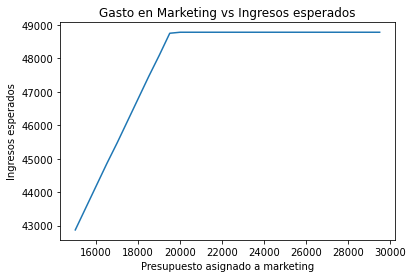

In [38]:
# Celda: 35

plt.plot(gasto_mkt["Presupuesto"],gasto_mkt["Ingresos"])
plt.xlabel("Presupuesto asignado a marketing")
plt.ylabel("Ingresos esperados")
plt.title("Gasto en Marketing vs Ingresos esperados")
plt.show()

### Conclusión

Debido a las limitaciones comerciales, puede dirigirse a un máximo de 953 clientes con un presupuesto de $ 19,719.

Los fondos disponibles por encima de esa cantidad no se gastarán.

El ingreso esperado es de $ 48,780.

### Visualización de la solución

In [39]:
# Celda: 36

# Extraer el valor de la solución en un dataframe
assignments_df = pd.DataFrame({'assignment': canalesVar})
assignments_df.index.names=['Cliente', 'Producto', 'Canal']
assignments_df = assignments_df.assignment.apply(lambda v: v.solution_value)

# Mantener solo los assigments seleccionados
assignments_df = assignments_df[assignments_df == 1]
assignments_df.head()

Cliente  Producto  Canal
0        0         0        1.0
2        1         0        1.0
4        0         0        1.0
6        1         0        1.0
8        0         0        1.0
Name: assignment, dtype: float64

In [40]:
# Celda: 37

assignments_df = assignments_df.to_frame()

In [41]:
# Celda: 38

assignments_df.to_csv('prueba.csv')
assignments_df = pd.read_csv('prueba.csv')

In [42]:
# Celda: 39

assignments_df['Producto'] = assignments_df['Producto'].apply(lambda x: 'tarjeta_credito' if x==0 else ('prestamo_hipotecario' if x == 1 else 'None'))
assignments_df['Canal'] = assignments_df['Canal'].apply(lambda x: 'llamada_telefonica' if x==0 else ('email' if x == 1 else ('redes_sociales' if x == 2 else 'None')))
assignments_df.drop(['assignment'], axis=1, inplace=True )
assignments_df

,Cliente,Producto,Canal
0,0,tarjeta_credito,llamada_telefonica
1,2,prestamo_hipotecario,llamada_telefonica
2,4,tarjeta_credito,llamada_telefonica
3,6,prestamo_hipotecario,llamada_telefonica
4,8,tarjeta_credito,llamada_telefonica
...,...,...,...
948,1988,prestamo_hipotecario,llamada_telefonica
949,1989,tarjeta_credito,llamada_telefonica
950,1993,tarjeta_credito,llamada_telefonica
951,1997,tarjeta_credito,llamada_telefonica


In [45]:
assignments_df.shape

(953, 3)

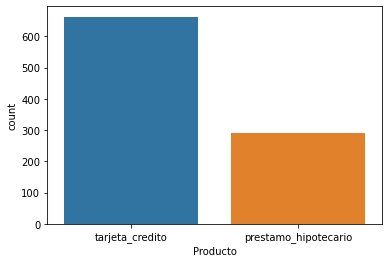

In [46]:
# Celda: 40
import seaborn as sns
sns.countplot(x=assignments_df['Producto'],data=assignments_df)

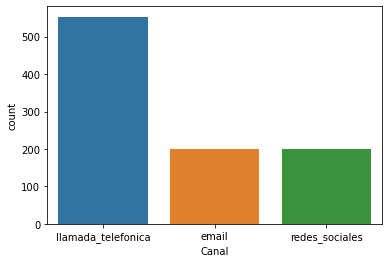

In [47]:
sns.countplot(x=assignments_df['Canal'],data=assignments_df)

## Referencias

Este notebook es una adaptación de:
* <a href="https://dataplatform.cloud.ibm.com/exchange/public/entry/view/37d8b0ccf1abb870fde60a6ccdd2ec63" target="_blank" rel="noopener noreferrer">Promoting financial products to bank customers</a>

### Authors

**Alain Chabrier**  IBM, France.

**Vincent Beraudier** IBM, France.